In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_array
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data

from cci.utils import get_adata
from cci.data import dataset_application_poster, save_application_experiment, load_application_experiment
from cci.models import MultilayerNode2Vec

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "

In [2]:
case = "joint"

with timebudget("loading data"):
    data, df, graph_hparams = dataset_application_poster(case = case)

loading data took 6.382sec


In [3]:
graph_hparams

{'case': 'joint',
 'd': 0.04,
 'L_thr': 0.0,
 'R_thr': 0.0,
 'lr_gene_pairs': [['Tac2', 'Tacr3'],
  ['Penk', 'Oprd1'],
  ['Pdyn', 'Oprd1'],
  ['Pdyn', 'Oprk1'],
  ['Grp', 'Grpr']],
 'n_layers': 1,
 'num_nodes': 9242}

In [4]:
# MultilayerNode2vec hyperparameters
n2v_params = dict(p=1.0, 
                q=1.0, 
                embedding_dim=15,
                walk_length=10,
                context_size=10,
                walks_per_node=1,
                num_negative_samples_per_layer=1,
                num_nodes=graph_hparams["num_nodes"],
                batch_size=128)

device = "cpu"
model_dict = {}
loader_dict = {}
optimizer_dict = {}
for i in range(graph_hparams["n_layers"]):
    model_dict[i] = MultilayerNode2Vec(data.edge_index_list, **n2v_params, sparse=True).to(device)
    loader_dict[i] = model_dict[i].loader(batch_size=n2v_params['batch_size'], shuffle=True)
    optimizer_dict[i] = torch.optim.SparseAdam(list(model_dict[i].parameters()), lr=0.01)


def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def get_z(model_dict):
    z_list = [None] * len(model_dict.values())
    for i, model in enumerate(model_dict.values()):
        model.eval()
        z_list[i] = model()
        z_list[i] = z_list[i].detach().cpu().numpy()
    z = np.concatenate(z_list, axis=1)
    del z_list
    return z

@torch.no_grad()
def test(model_dict):
    z = get_z(model_dict)
    clf = LogisticRegression().fit(z[data.train_idx], data.labels[data.train_idx])
    acc_test = clf.score(z[data.test_idx], data.labels[data.test_idx])
    keep_idx = np.concatenate([data.train_idx, data.test_idx])
    acc_overall = clf.score(z[keep_idx], data.labels[keep_idx])
    return acc_test, acc_overall


def show_embeddings(z, df, savepath=None):
    if savepath is not None:
        assert savepath.endswith(".png"), "savepath should end with .png"
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    z_tsne = tsne.fit_transform(z)

    keep = df["participant"].values
    subclass_color_dict = df[["subclass_color", "subclass"]].drop_duplicates()
    subclass_color_dict = subclass_color_dict.set_index("subclass").to_dict()["subclass_color"] 
    f, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(x=z_tsne[keep, 0], y=z_tsne[keep, 1], hue=df["subclass"][keep], 
                    palette=subclass_color_dict, s=5, linewidth=0, ax=ax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis("off")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath.replace(".png", "_subclass.png"), dpi=300)
    else:
        plt.show()

    f, ax = plt.subplots(figsize=(5, 5))
    participant_color_dict = {True: "darkgrey", False: "whitesmoke"}
    sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=df["participant"], 
                    palette=participant_color_dict, s=3, linewidth=0, ax=ax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis("off")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath.replace(".png", "_participant.png"), dpi=300)
    else:
        plt.show()

    plt.show()
    return z_tsne

Epoch: 010, Loss: 1.0179, Test accuracy: 0.2424, Overall accuracy: 0.2535
Epoch: 020, Loss: 0.8841, Test accuracy: 0.2573, Overall accuracy: 0.2687
Epoch: 030, Loss: 0.8482, Test accuracy: 0.2729, Overall accuracy: 0.2811
Epoch: 040, Loss: 0.8358, Test accuracy: 0.2847, Overall accuracy: 0.2919
Epoch: 050, Loss: 0.8283, Test accuracy: 0.3012, Overall accuracy: 0.3031
Epoch: 060, Loss: 0.8271, Test accuracy: 0.3169, Overall accuracy: 0.3064
Epoch: 070, Loss: 0.8250, Test accuracy: 0.3208, Overall accuracy: 0.3120
Epoch: 080, Loss: 0.8238, Test accuracy: 0.3239, Overall accuracy: 0.3149
Epoch: 090, Loss: 0.8227, Test accuracy: 0.3200, Overall accuracy: 0.3196
Epoch: 100, Loss: 0.8236, Test accuracy: 0.3349, Overall accuracy: 0.3273
Epoch: 110, Loss: 0.8225, Test accuracy: 0.3318, Overall accuracy: 0.3287
Epoch: 120, Loss: 0.8222, Test accuracy: 0.3373, Overall accuracy: 0.3320
Epoch: 130, Loss: 0.8222, Test accuracy: 0.3420, Overall accuracy: 0.3332
Epoch: 140, Loss: 0.8226, Test accurac

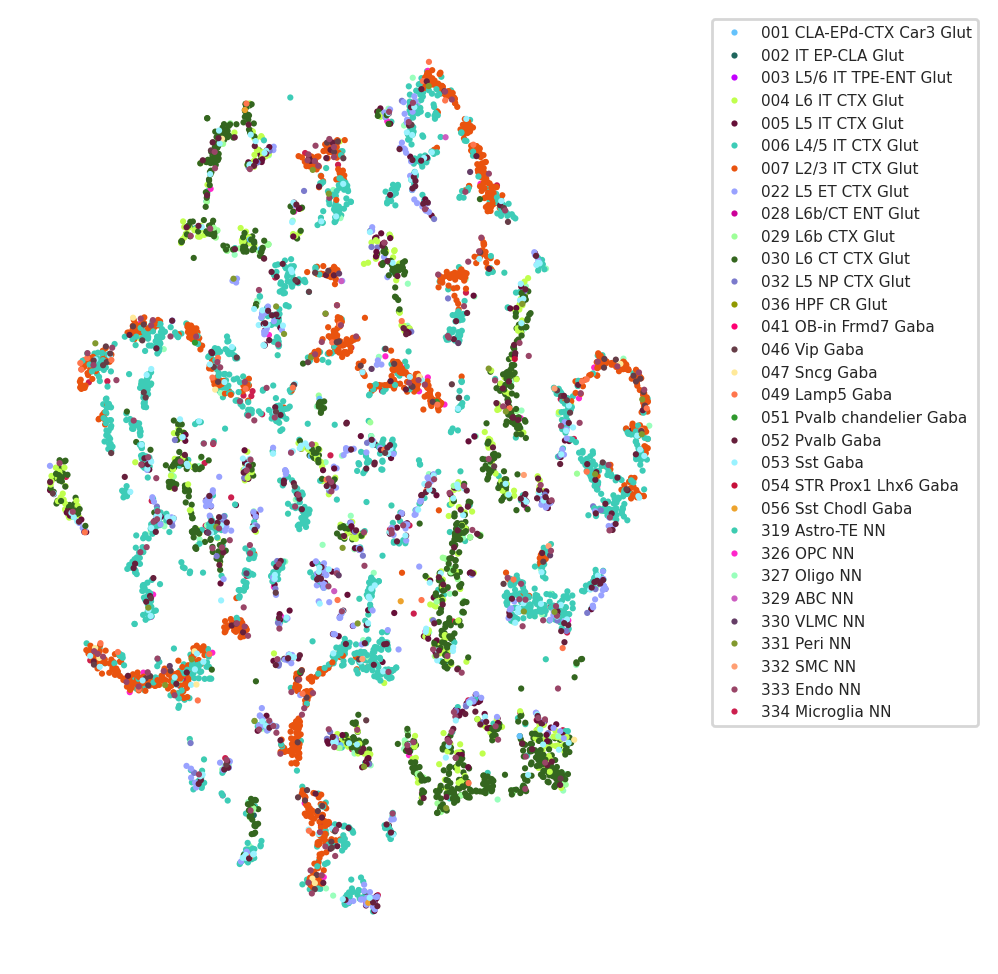

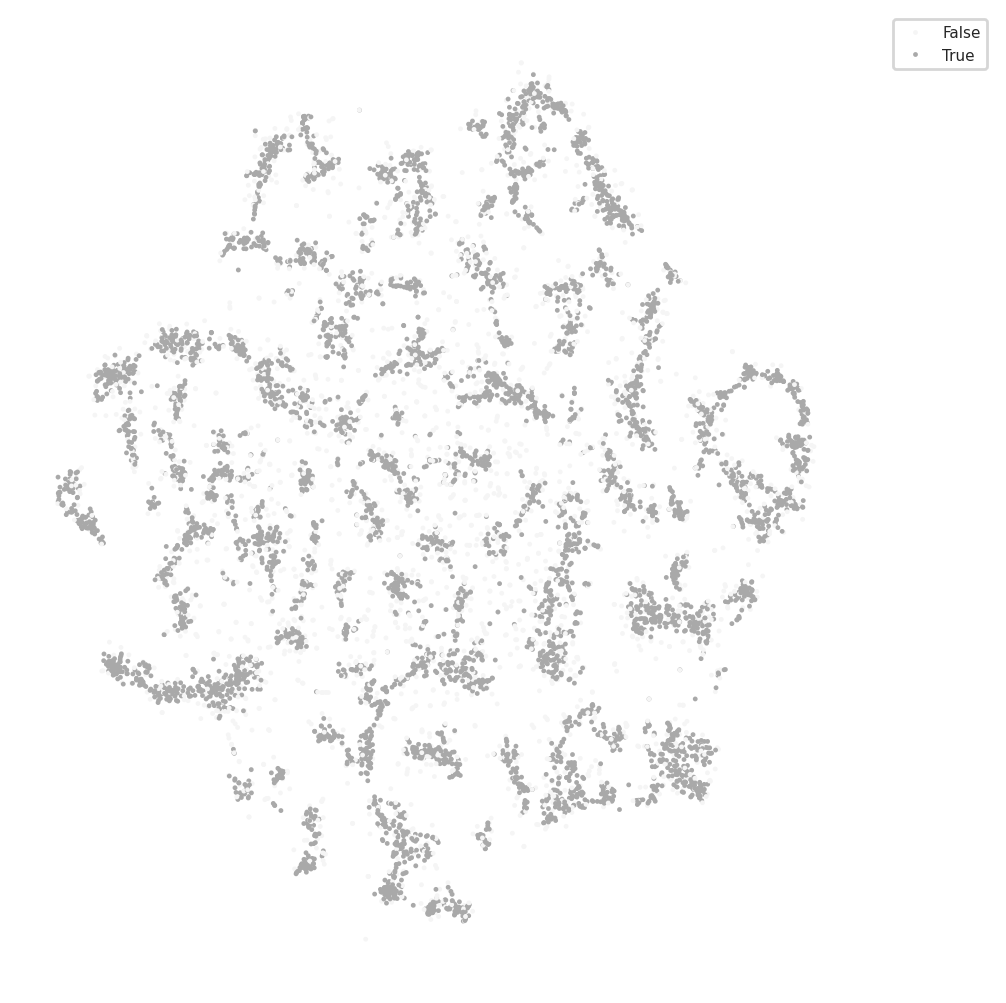

Epoch: 210, Loss: 0.8201, Test accuracy: 0.3357, Overall accuracy: 0.3367
Epoch: 220, Loss: 0.8215, Test accuracy: 0.3404, Overall accuracy: 0.3445
Epoch: 230, Loss: 0.8211, Test accuracy: 0.3522, Overall accuracy: 0.3467
Epoch: 240, Loss: 0.8206, Test accuracy: 0.3529, Overall accuracy: 0.3437
Epoch: 250, Loss: 0.8204, Test accuracy: 0.3459, Overall accuracy: 0.3475
Epoch: 260, Loss: 0.8208, Test accuracy: 0.3459, Overall accuracy: 0.3488
Epoch: 270, Loss: 0.8204, Test accuracy: 0.3435, Overall accuracy: 0.3423
Epoch: 280, Loss: 0.8211, Test accuracy: 0.3561, Overall accuracy: 0.3485
Epoch: 290, Loss: 0.8201, Test accuracy: 0.3420, Overall accuracy: 0.3448
Epoch: 300, Loss: 0.8199, Test accuracy: 0.3443, Overall accuracy: 0.3481
Epoch: 310, Loss: 0.8192, Test accuracy: 0.3388, Overall accuracy: 0.3444
Epoch: 320, Loss: 0.8201, Test accuracy: 0.3506, Overall accuracy: 0.3458
Epoch: 330, Loss: 0.8196, Test accuracy: 0.3522, Overall accuracy: 0.3519
Epoch: 340, Loss: 0.8192, Test accurac

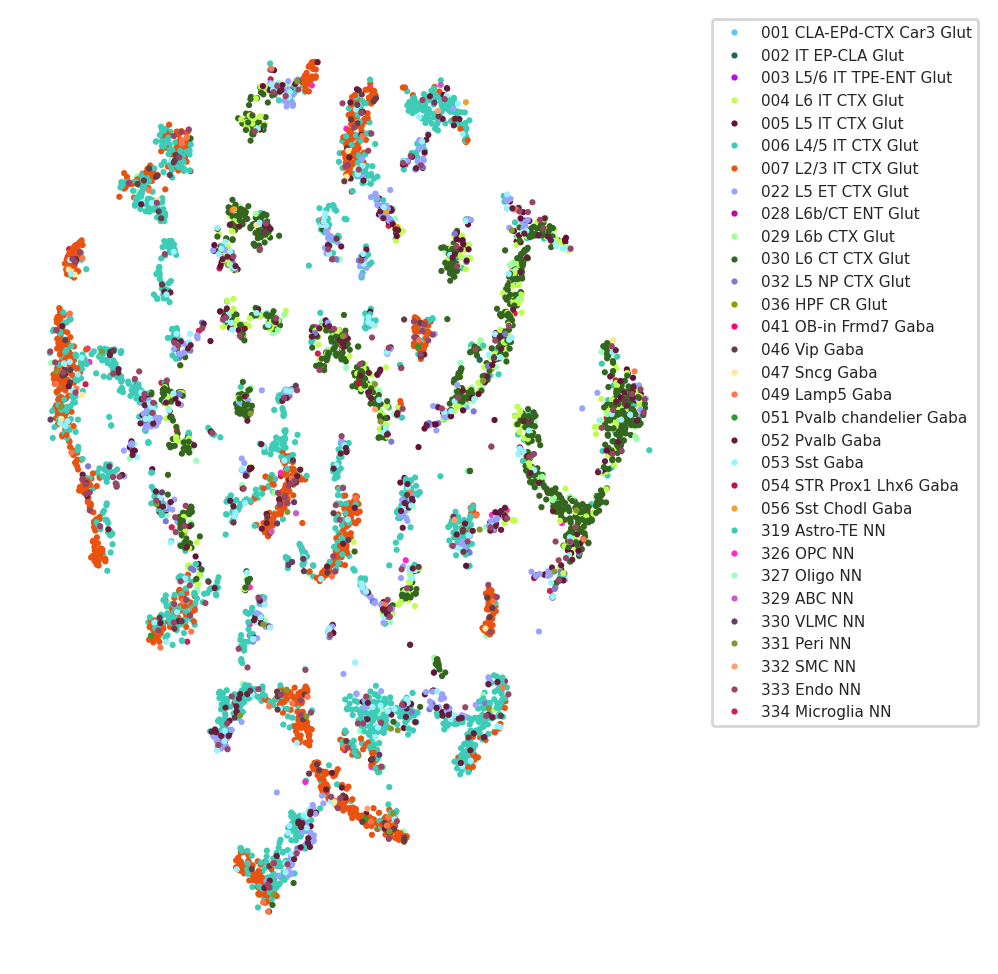

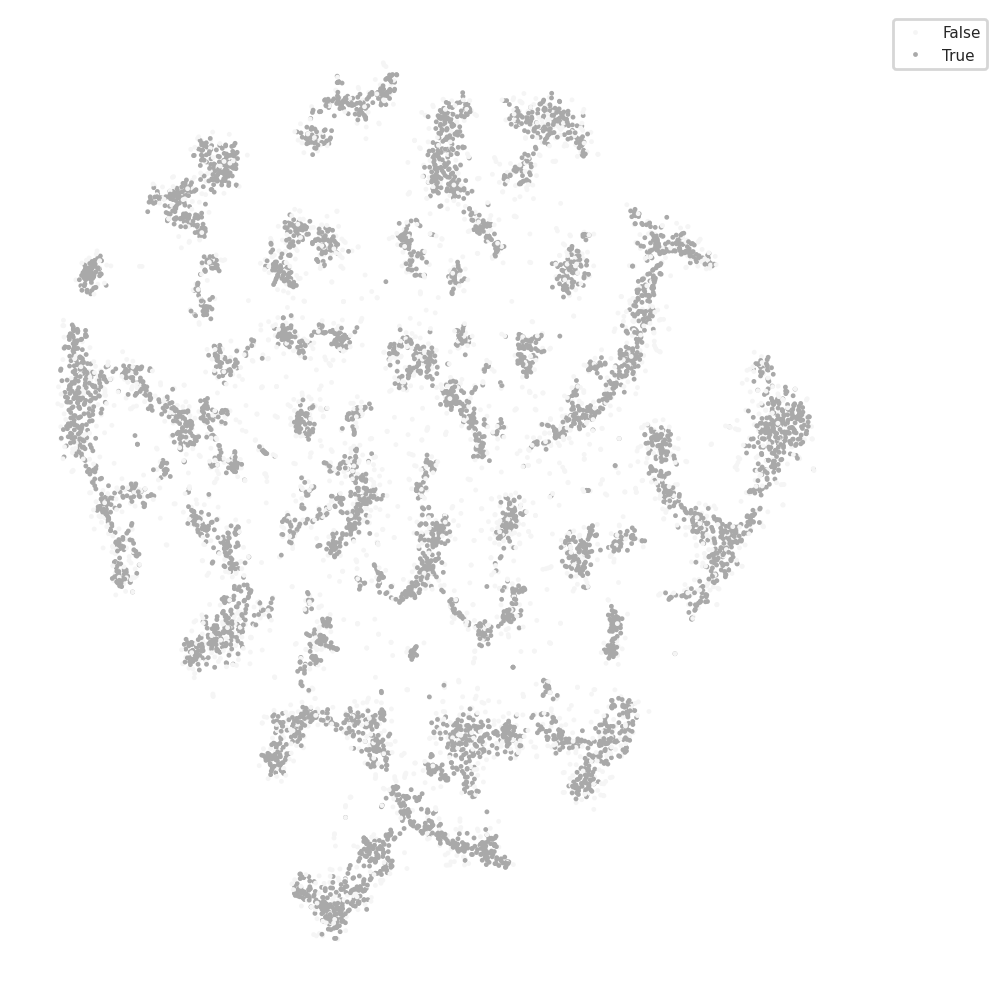

Epoch: 410, Loss: 0.8187, Test accuracy: 0.3506, Overall accuracy: 0.3497
Epoch: 420, Loss: 0.8195, Test accuracy: 0.3435, Overall accuracy: 0.3533
Epoch: 430, Loss: 0.8195, Test accuracy: 0.3373, Overall accuracy: 0.3496
Epoch: 440, Loss: 0.8189, Test accuracy: 0.3443, Overall accuracy: 0.3472
Epoch: 450, Loss: 0.8183, Test accuracy: 0.3435, Overall accuracy: 0.3525
Epoch: 460, Loss: 0.8186, Test accuracy: 0.3420, Overall accuracy: 0.3532
Epoch: 470, Loss: 0.8177, Test accuracy: 0.3514, Overall accuracy: 0.3554
Epoch: 480, Loss: 0.8191, Test accuracy: 0.3584, Overall accuracy: 0.3612
Epoch: 490, Loss: 0.8189, Test accuracy: 0.3686, Overall accuracy: 0.3660
Epoch: 500, Loss: 0.8188, Test accuracy: 0.3678, Overall accuracy: 0.3626
Epoch: 510, Loss: 0.8177, Test accuracy: 0.3647, Overall accuracy: 0.3629
Epoch: 520, Loss: 0.8171, Test accuracy: 0.3584, Overall accuracy: 0.3612
Epoch: 530, Loss: 0.8184, Test accuracy: 0.3545, Overall accuracy: 0.3631
Epoch: 540, Loss: 0.8180, Test accurac

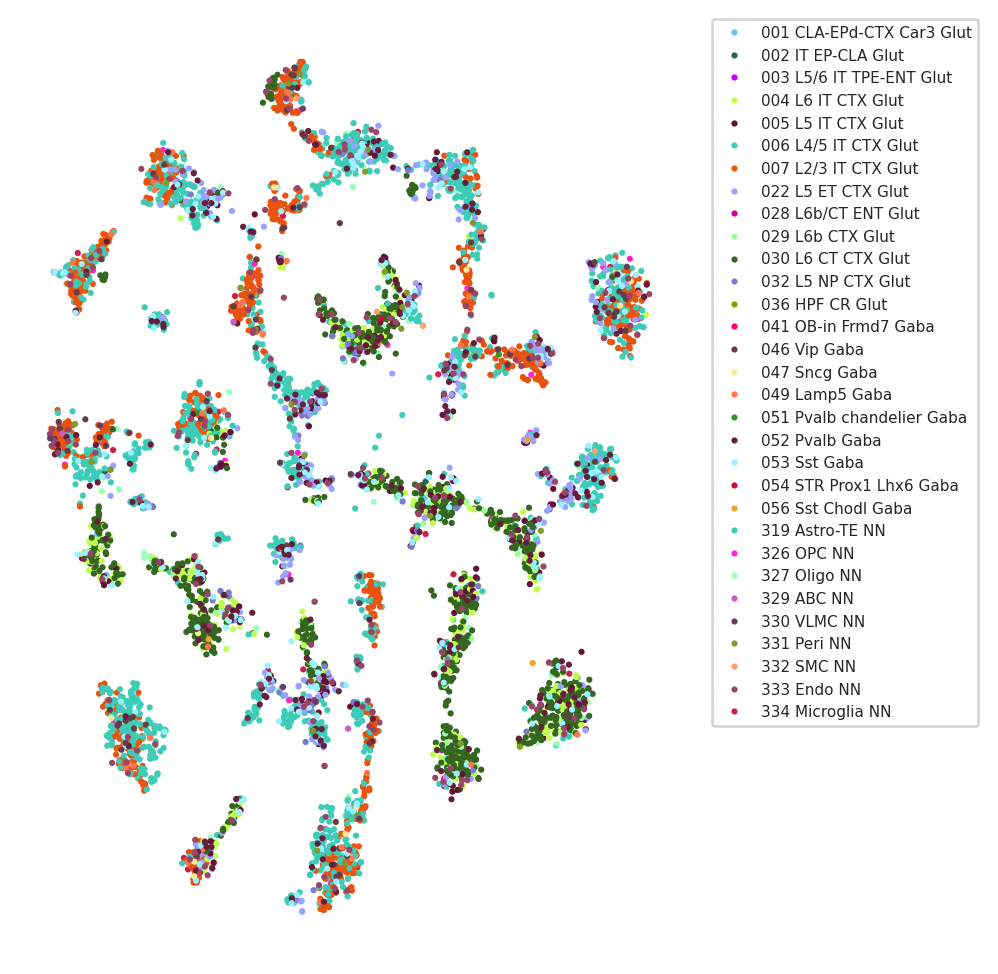

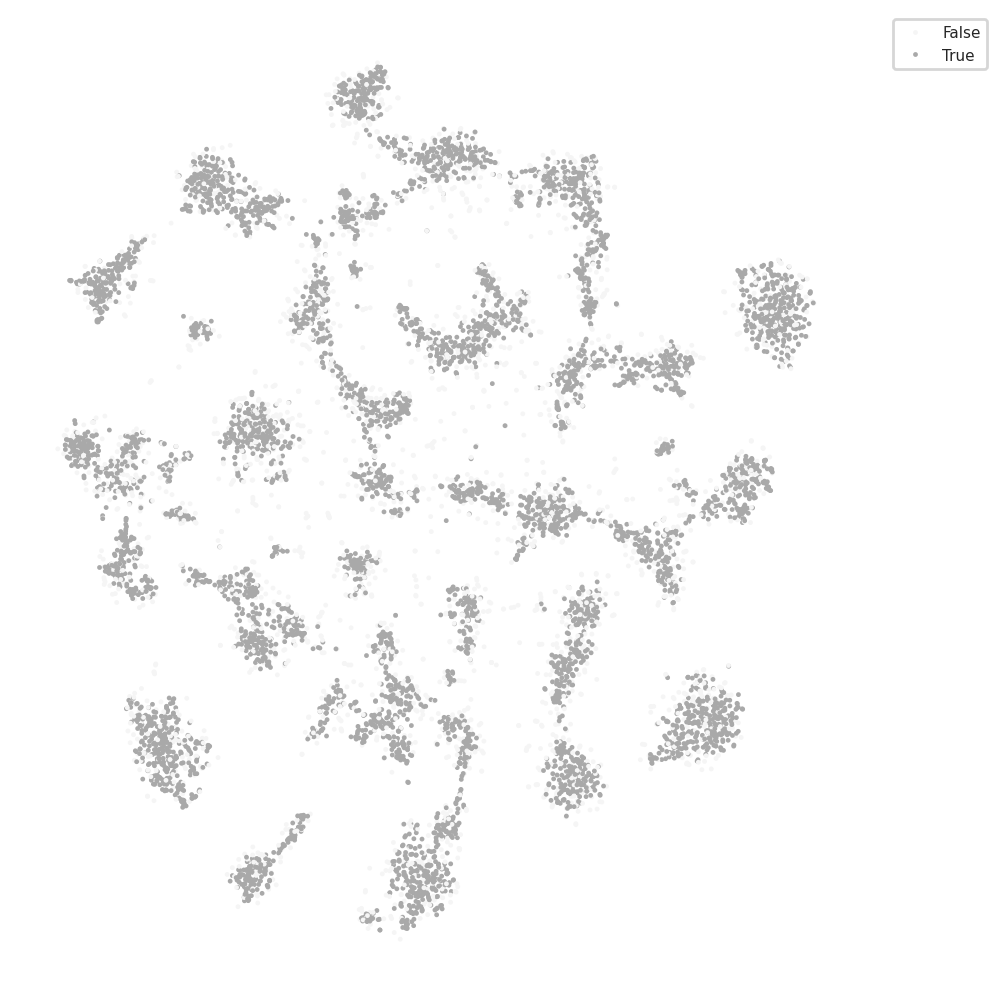

Epoch: 610, Loss: 0.8160, Test accuracy: 0.3796, Overall accuracy: 0.3791
Epoch: 620, Loss: 0.8171, Test accuracy: 0.3702, Overall accuracy: 0.3814
Epoch: 630, Loss: 0.8160, Test accuracy: 0.3655, Overall accuracy: 0.3839
Epoch: 640, Loss: 0.8166, Test accuracy: 0.3757, Overall accuracy: 0.3842
Epoch: 650, Loss: 0.8155, Test accuracy: 0.3624, Overall accuracy: 0.3786
Epoch: 660, Loss: 0.8159, Test accuracy: 0.3765, Overall accuracy: 0.3844
Epoch: 670, Loss: 0.8169, Test accuracy: 0.3749, Overall accuracy: 0.3858
Epoch: 680, Loss: 0.8152, Test accuracy: 0.3804, Overall accuracy: 0.3904
Epoch: 690, Loss: 0.8155, Test accuracy: 0.3882, Overall accuracy: 0.3913
Epoch: 700, Loss: 0.8161, Test accuracy: 0.3804, Overall accuracy: 0.3904
Epoch: 710, Loss: 0.8155, Test accuracy: 0.3898, Overall accuracy: 0.3962
Epoch: 720, Loss: 0.8155, Test accuracy: 0.3890, Overall accuracy: 0.3968
Epoch: 730, Loss: 0.8151, Test accuracy: 0.4063, Overall accuracy: 0.4006
Epoch: 740, Loss: 0.8136, Test accurac

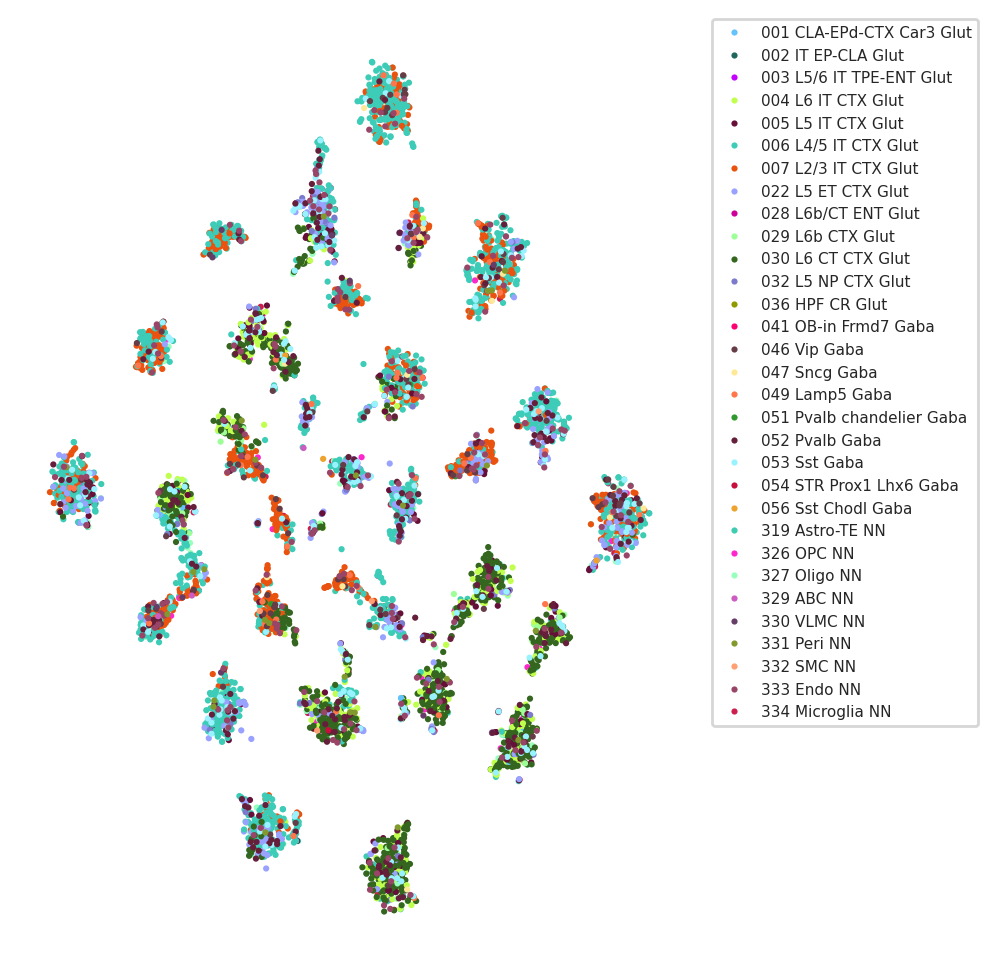

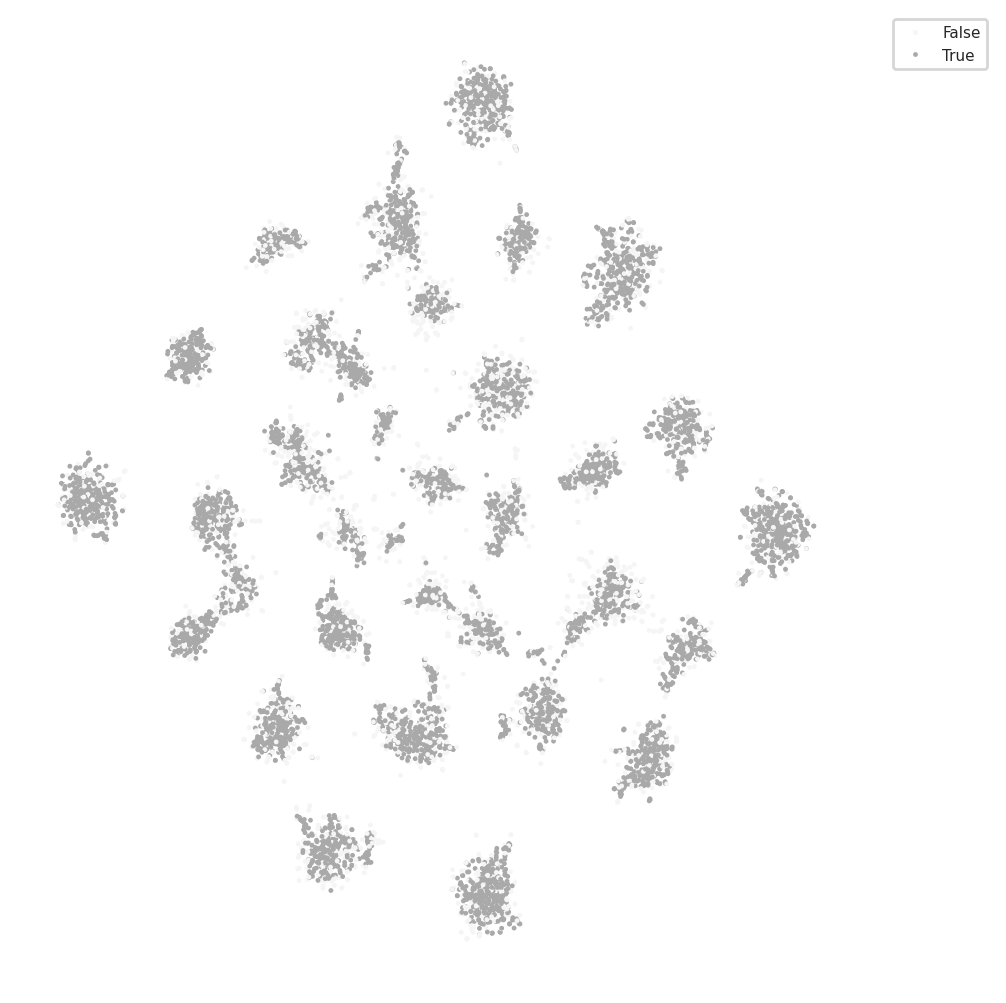

Epoch: 810, Loss: 0.8144, Test accuracy: 0.3976, Overall accuracy: 0.4075
Epoch: 820, Loss: 0.8147, Test accuracy: 0.3953, Overall accuracy: 0.4021
Epoch: 830, Loss: 0.8137, Test accuracy: 0.4008, Overall accuracy: 0.4076
Epoch: 840, Loss: 0.8143, Test accuracy: 0.3906, Overall accuracy: 0.4073
Epoch: 850, Loss: 0.8142, Test accuracy: 0.4031, Overall accuracy: 0.4087
Epoch: 860, Loss: 0.8162, Test accuracy: 0.3945, Overall accuracy: 0.4050
Epoch: 870, Loss: 0.8146, Test accuracy: 0.3922, Overall accuracy: 0.4050
Epoch: 880, Loss: 0.8135, Test accuracy: 0.3843, Overall accuracy: 0.4065
Epoch: 890, Loss: 0.8138, Test accuracy: 0.3945, Overall accuracy: 0.4039
Epoch: 900, Loss: 0.8142, Test accuracy: 0.3992, Overall accuracy: 0.4070
Epoch: 910, Loss: 0.8146, Test accuracy: 0.3953, Overall accuracy: 0.4090
Epoch: 920, Loss: 0.8129, Test accuracy: 0.3961, Overall accuracy: 0.4059
Epoch: 930, Loss: 0.8141, Test accuracy: 0.4118, Overall accuracy: 0.4076
Epoch: 940, Loss: 0.8134, Test accurac

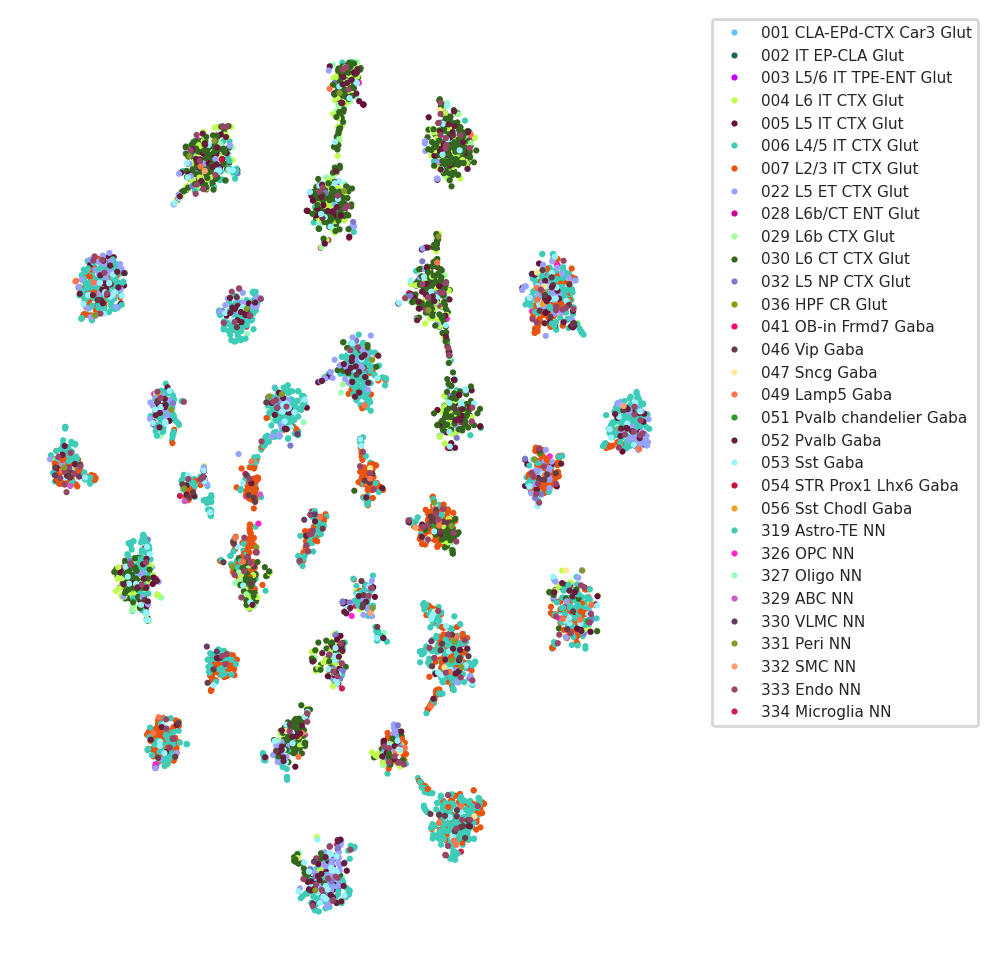

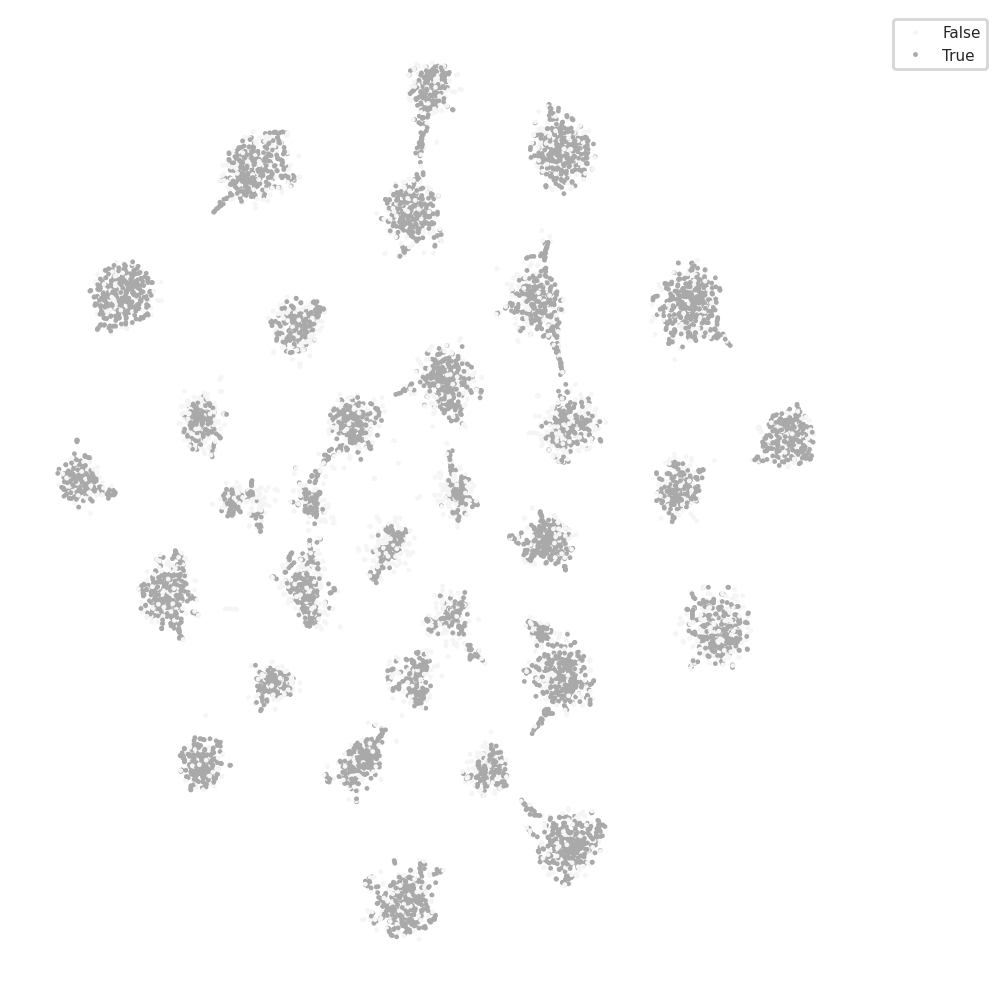

In [5]:
# model training:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    loss = [None] * graph_hparams["n_layers"]
    for i in range(graph_hparams["n_layers"]):
        loss[i] = train(model_dict[i], loader_dict[i], optimizer_dict[i])
    loss = sum(loss)

    if epoch % 10 == 0:
        acc_test, acc_overall = test(model_dict)
        print(
            f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test accuracy: {acc_test:.4f}, Overall accuracy: {acc_overall:.4f}"
        )
    if epoch % 200 == 0:
        print(f"Epoch: {epoch:03d} embeddings")
        z = get_z(model_dict)
        z_tsne = show_embeddings(z, df)
        fname = f"case_{graph_hparams['case']}_epoch_{epoch:05d}.pkl"
        save_application_experiment(fname=fname, 
                                    epoch=epoch, 
                                    z=z, 
                                    df=df, 
                                    graph_hparams=graph_hparams,
                                    leiden_partitions=None, 
                                    z_tsne=z_tsne)


In [6]:
import leidenalg as la
import igraph as ig
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph

100%|██████████| 6371/6371 [00:24<00:00, 256.71it/s]


Found 32 partitions


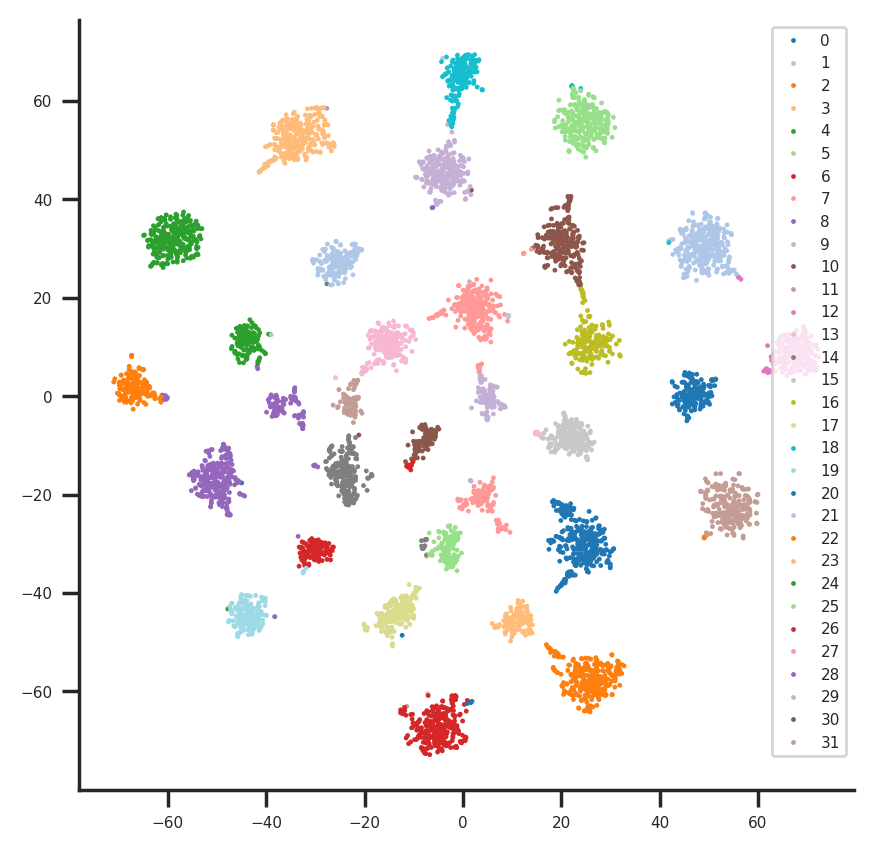

In [7]:

keep = df["participant"].values

# create a knn graph with z as positions
knn_graph = kneighbors_graph(z[keep], n_neighbors=5, mode="connectivity", include_self=False)

# convert to igraph
g = ig.Graph(directed=False)
g.add_vertices(knn_graph.shape[0])

for i in tqdm(range(knn_graph.shape[0])):
    for j in knn_graph[i].indices:
        g.add_edge(i, j)

# run leiden community detection
partition = la.find_partition(g, la.ModularityVertexPartition)
n_partitions = np.unique(partition.membership).size
print(f"Found {n_partitions} partitions")

# project labels on tsne
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=z_tsne[keep, 0], y=z_tsne[keep, 1], hue=partition.membership, palette="tab20", s=3, linewidth=0, ax=ax)
plt.show()

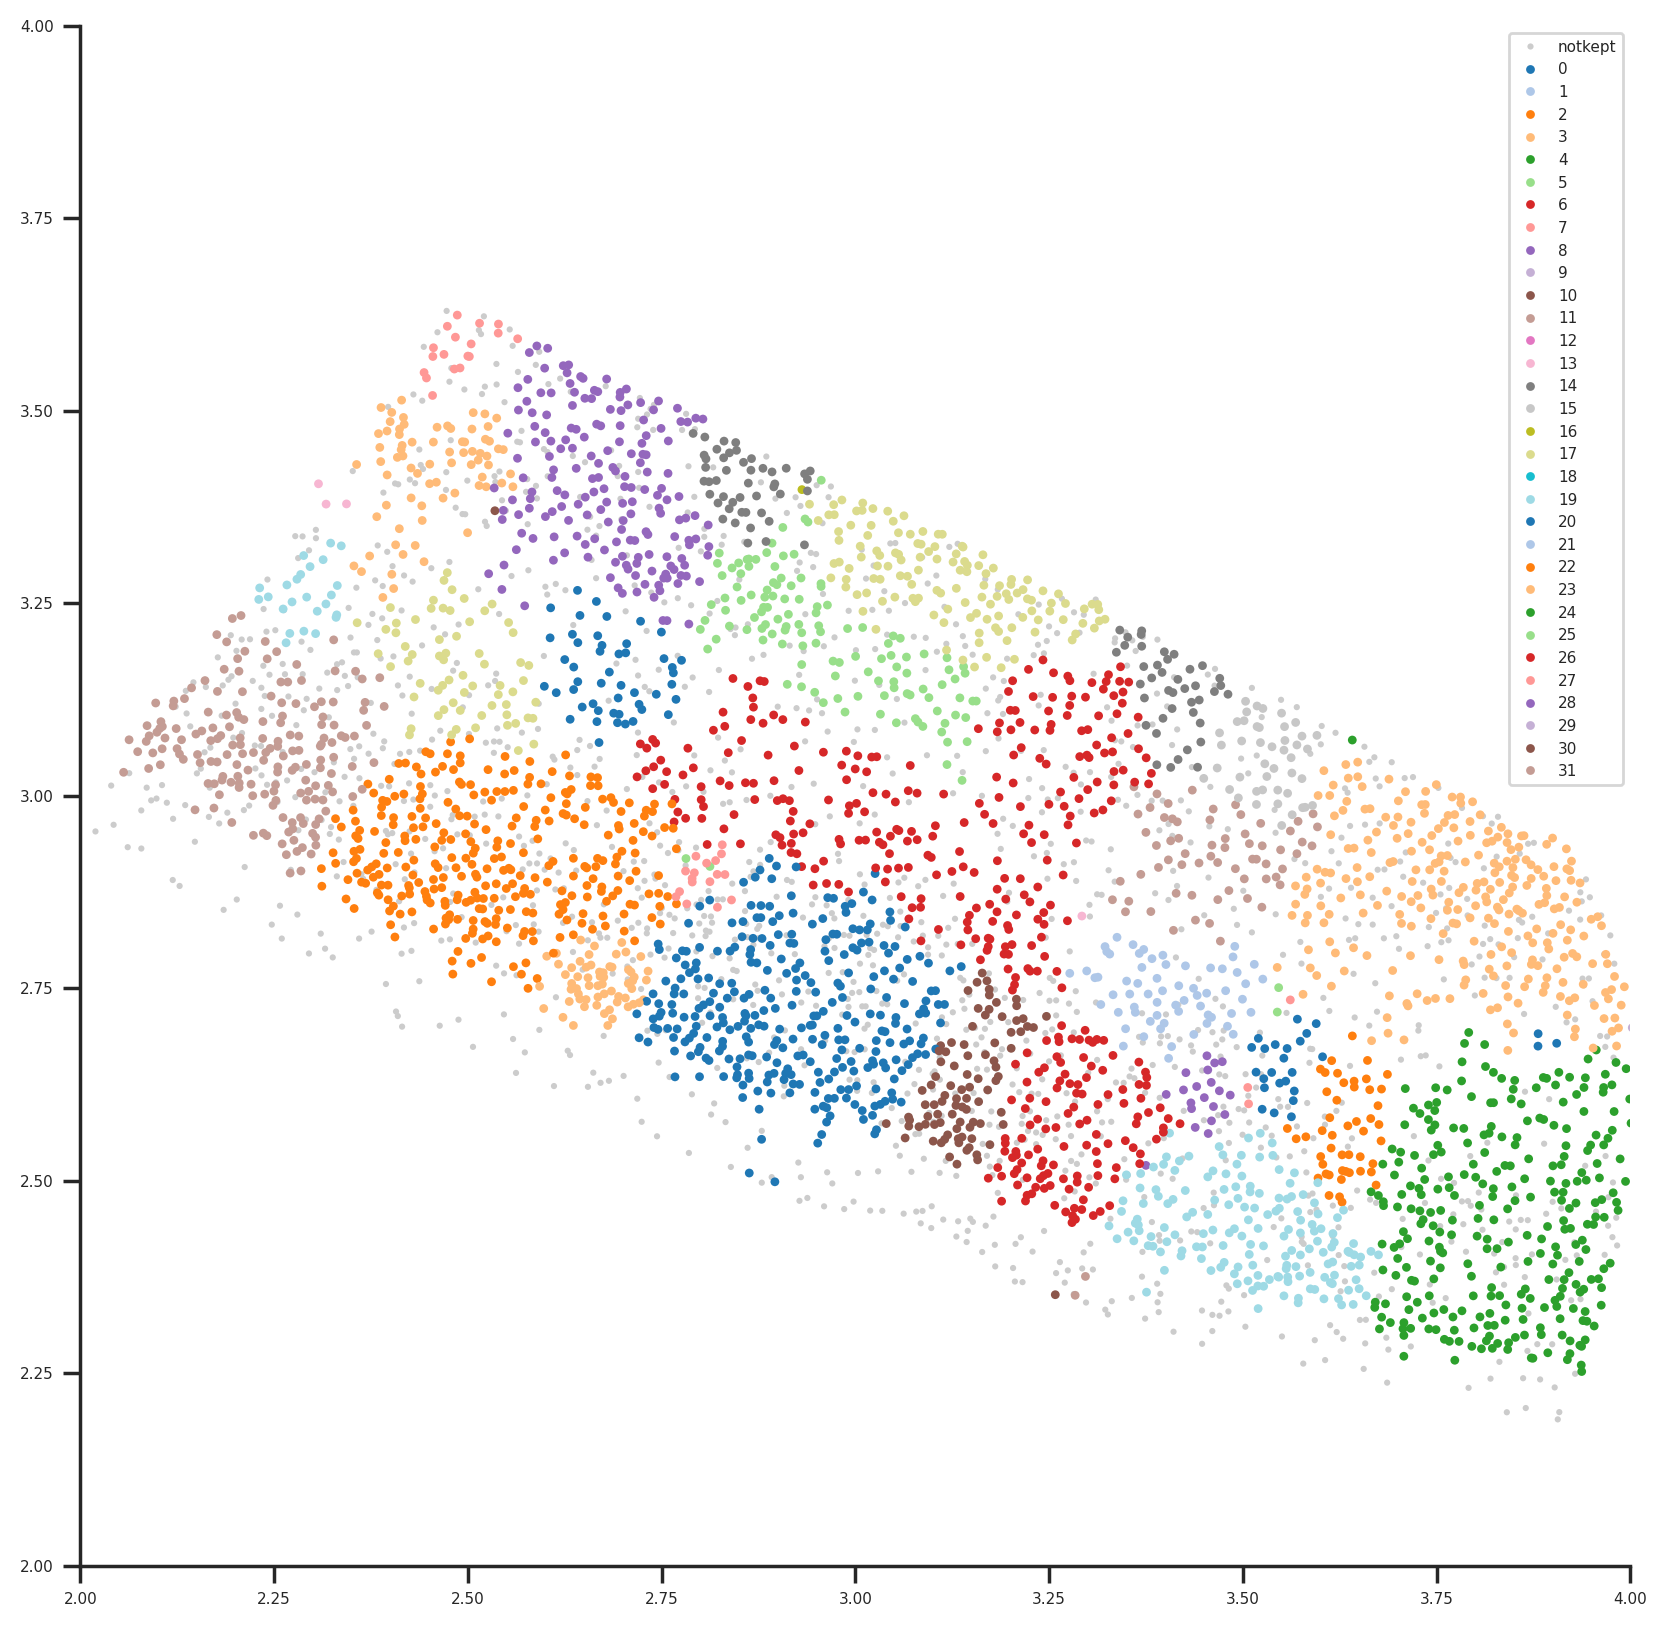

In [8]:
# project labels on brain co-ordinates
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=df["x_reconstructed"].values[~keep], 
                y=df["y_reconstructed"].values[~keep], 
                hue=np.array(["notkept"]*np.sum(~keep)),
                s=5, linewidth=0, ax=ax, palette=dict(notkept="#cccccc"))
sns.scatterplot(x=df["x_reconstructed"].values[keep], 
                y=df["y_reconstructed"].values[keep], 
                hue=partition.membership, palette="tab20", 
                s=10, linewidth=0, ax=ax)
ax.set(ylim = (2, 4), xlim = (2, 4))
plt.show()

fname = f"case_{graph_hparams['case']}_epoch_{epoch:05d}.pkl"
save_application_experiment(fname=fname, 
                            epoch=epoch, 
                            z=z, 
                            df=df, 
                            graph_hparams=graph_hparams,
                            n2v_params=n2v_params,
                            leiden_partitions=partition.membership, 
                            z_tsne=z_tsne)